In [1]:
# MA Cross Backtesting on 1H BTC on lower granularity
# - Taker fee               is 0.05%
# - Initial capital         is 10000.0$
# - Timeframe               is 1H
# 

In [2]:
import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import yfinance          as yf
import pandas            as pd
import numpy             as np
import quantstats        as qs
import matplotlib.pyplot as plt

In [3]:
df_ = pd.read_csv("./data/crypto-spot/BTCUSDT.csv", parse_dates=True, index_col=0)
df_.index = pd.to_datetime(df_.index, format='mixed')
df_.index = pd.DatetimeIndex(df_.index)
df_

,Open,High,Low,Close,Volume
date,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796
...,...,...,...,...,...
2024-01-31 23:55:00,42611.31,42614.98,42607.91,42614.98,8.673160
2024-01-31 23:56:00,42614.98,42617.80,42610.55,42617.80,4.741770
2024-01-31 23:57:00,42617.80,42617.80,42617.79,42617.80,1.950260


In [4]:
hours               = 1
timeframe_by_minute = hours*60
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4315.32,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4324.35,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2024-01-31 19:00:00,43513.38,43551.99,43041.10,43334.64,2549.594580
2024-01-31 20:00:00,43334.63,43361.10,42519.92,42541.18,3928.704250
2024-01-31 21:00:00,42541.19,42707.68,42276.84,42487.12,3017.454020


In [5]:
# Signal extraction

df['MA50' ] = df['Close'].rolling(window=20).mean()
df['MA200'] = df['Close'].rolling(window=50).mean()

df['Signal'] = 0
df.loc[((df['MA50'] > df['MA200']) & (df['MA50'].shift(1) <= df['MA200'].shift(1))), 'Signal'] =  1
df.loc[((df['MA50'] < df['MA200']) & (df['MA50'].shift(1) >= df['MA200'].shift(1))), 'Signal'] = -1

In [6]:
df['Signal'].value_counts()

Signal
 0    55145
 1      670
-1      670
Name: count, dtype: int64

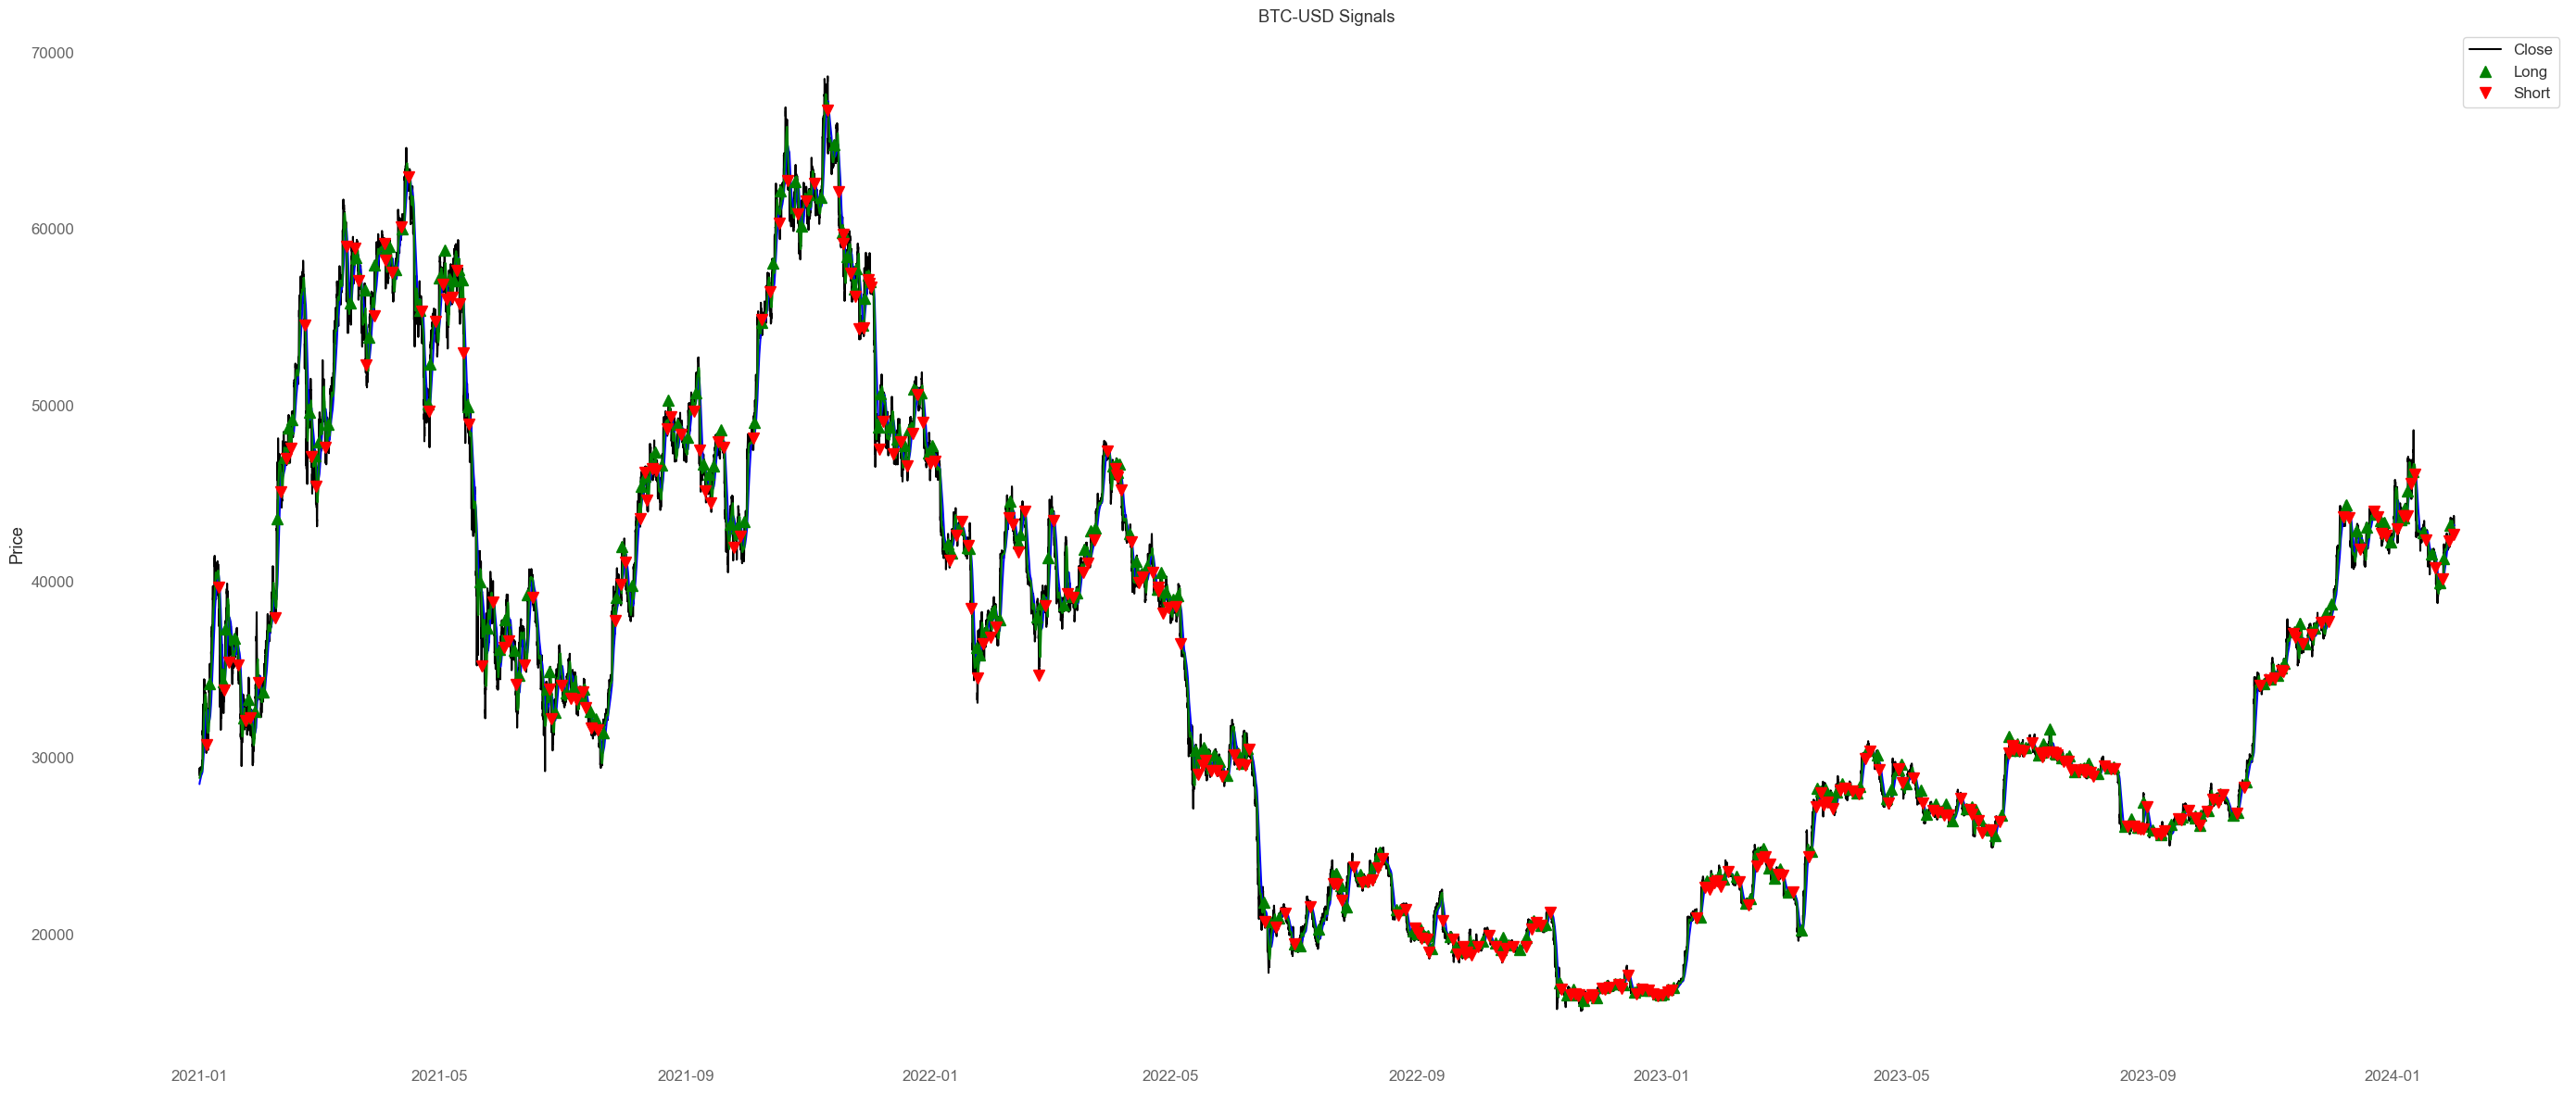

In [7]:
plot_df = df["2021-01-01":]

fig, ax1 = plt.subplots(1, figsize=(28, 12), sharex=True)

ax1.plot(plot_df.index, plot_df['Close'], label='Close', color='black')
ax1.plot(plot_df['MA200'], color='blue' )
ax1.plot(plot_df['MA50' ], color='green')
ax1.plot(plot_df[plot_df['Signal'] ==  1].index, plot_df[plot_df['Signal'] ==  1]['Close'], '^', markersize=8, color='green', label='Long' )
ax1.plot(plot_df[plot_df['Signal'] == -1].index, plot_df[plot_df['Signal'] == -1]['Close'], 'v', markersize=8, color='red'  , label='Short')
ax1.set_ylabel('Price')
ax1.set_title('BTC-USD Signals')
ax1.legend()
ax1.grid()

plt.tight_layout()
plt.show()

In [8]:
# Saving signals extracted on higher timeframe to lower granularity timeframe

df_eval = df_.copy(deep=True)

df_eval['Signal'] = 0

for idx, row in df[df['Signal']== 1].iterrows():
    if idx in df_eval.index:
        df_eval.loc[idx, 'Signal'] = 1

for idx, row in df[df['Signal']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.loc[idx, 'Signal'] = -1

look_ahead_shift = 1
df_eval['Signal' ] = df_eval['Signal' ].shift(hours*60+look_ahead_shift)

df_eval.dropna(inplace=True)

In [9]:
df_eval['Signal'].value_counts()

Signal
 0.0    3386765
 1.0        667
-1.0        666
Name: count, dtype: int64

In [10]:
# Position tracking

position         = 0
entry_timestamp  = None
entry_price      = 0
exit_timestamp   = None
exit_price       = 0
position_history = []

for index, row in df_eval.iterrows():
    if row['Signal'] != position:
        # Exit position
        if position != 0:
            exit_timestamp = index
            exit_price     = row['Close']
            pct_change     = (exit_price - entry_price) / entry_price
            position_history.append((entry_timestamp, exit_timestamp, entry_price, exit_price, pct_change))

        # Enter new position
        if row['Signal'] == 1:
            entry_timestamp = index
            entry_price     = row['Close']

        elif row['Signal'] == -1:
            entry_timestamp = index
            entry_price     = row['Close']

        position = row['Signal']

position_df = pd.DataFrame(position_history, columns=['Entry Time', 'Exit Time', 'Entry Price', 'Exit Price', 'Pct Change'])

position_df

,Entry Time,Exit Time,Entry Price,Exit Price,Pct Change
0,2017-08-20 14:01:00,2017-08-20 14:02:00,4063.35,4063.35,0.000000
1,2017-08-21 13:01:00,2017-08-21 13:02:00,4000.00,4000.00,0.000000
2,2017-08-23 04:01:00,2017-08-23 04:02:00,4078.88,4078.88,0.000000
3,2017-08-26 15:01:00,2017-08-26 15:02:00,4274.00,4274.00,0.000000
4,2017-08-27 12:01:00,2017-08-27 12:02:00,4323.37,4323.37,0.000000
...,...,...,...,...,...
1328,2024-01-26 05:01:00,2024-01-26 05:02:00,40171.19,40169.99,-0.000030
1329,2024-01-26 12:01:00,2024-01-26 12:02:00,41275.92,41243.99,-0.000774
1330,2024-01-29 11:01:00,2024-01-29 11:02:00,42291.11,42304.22,0.000310
1331,2024-01-29 17:01:00,2024-01-29 17:02:00,43275.67,43295.71,0.000463


<Axes: >

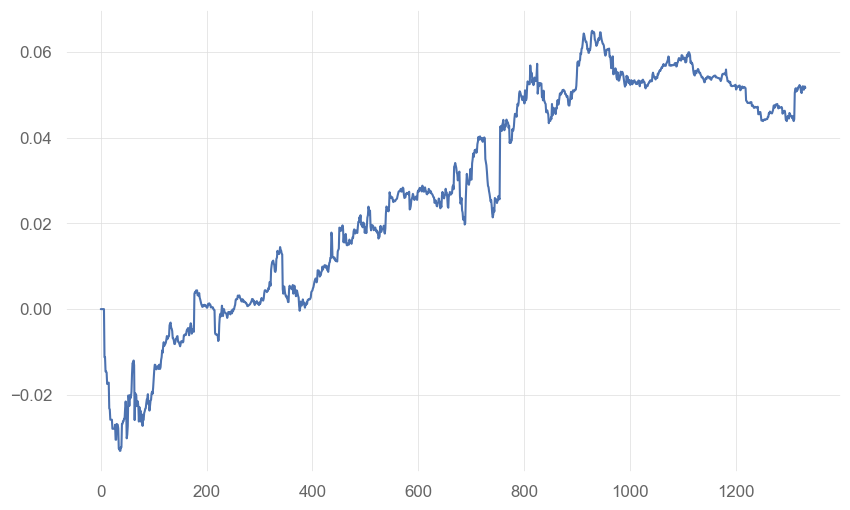

In [11]:
# Naive strategy performance
position_df['Pct Change'].cumsum().plot()

In [12]:
# Cost adjustment
position_df['LogReturn'] = (1+position_df['Pct Change']).apply(np.log)

taker_fee_pct        = 0.05  # Binance taker fee is 0.05%
transaction_cost_log = np.log(1-taker_fee_pct/100.0)
position_df['AdjustedLogReturn'] = position_df['LogReturn'] + transaction_cost_log

position_df['CumRet'            ] = 1+position_df['Pct Change'].cumsum()
position_df['CostAdjustedCumRet'] = position_df['AdjustedLogReturn'].cumsum().apply(np.exp)

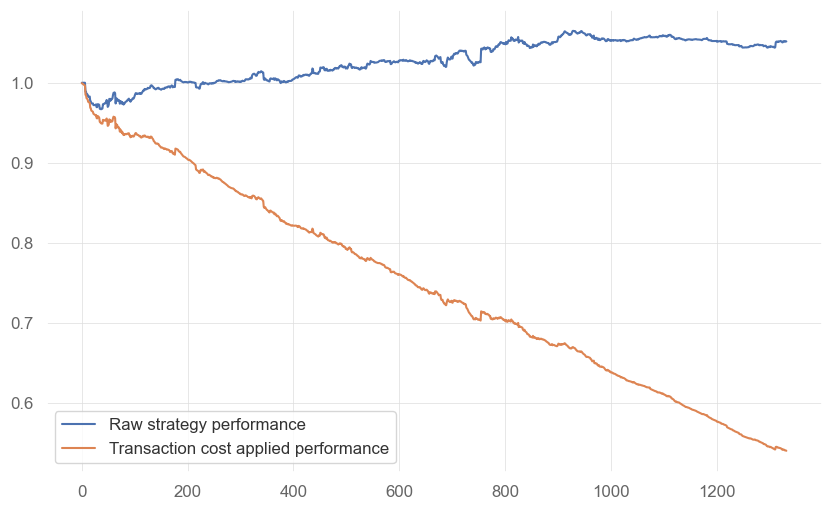

In [13]:
position_df[['CumRet', 'CostAdjustedCumRet']].plot()
plt.legend(['Raw strategy performance', 'Transaction cost applied performance'])

<Axes: >

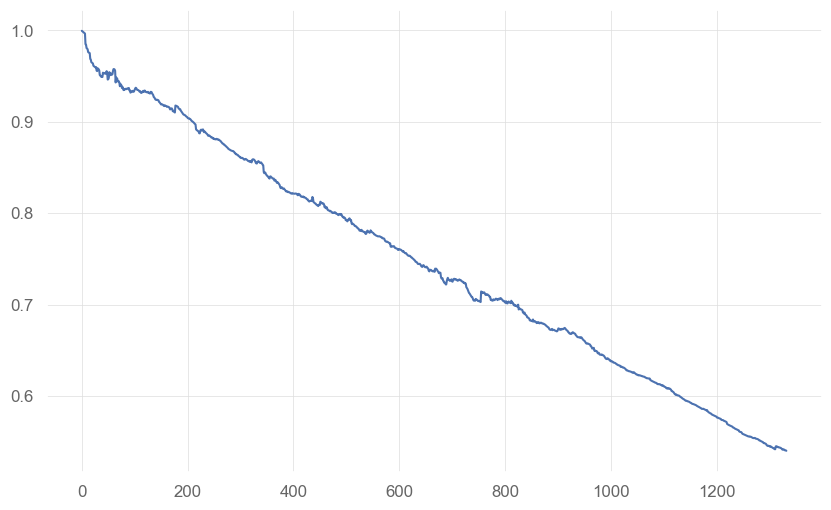

In [14]:
position_df['CostAdjustedCumRet'].plot()